In [24]:
!pip install datasets
!pip install -U accelerate
!pip install -U transformers
!pip install scikit-learn pillow torchvision opencv-python evaluate tensorboardx wandb transformers[torch] tf-keras


[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
import wandb 
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\kevin\_netrc


True

In [26]:
from sklearn.model_selection import train_test_split
from datasets import load_dataset, DatasetDict, load_metric

In [27]:
root_dir = r'C:\Users\kevin\Desktop\VSCode\Final Sem Project\dataset'

In [28]:
ds = load_dataset("imagefolder", data_dir=root_dir)

Resolving data files:   0%|          | 0/11325 [00:00<?, ?it/s]

In [29]:
ds = ds['train'].train_test_split(test_size=0.3, stratify_by_column="label")  # 70% train, 30% test
ds_test = ds['test'].train_test_split(test_size=0.5, stratify_by_column="label")  # 30% test --> 15% valid, 15% test
ds = DatasetDict({
    'train': ds['train'],
    'test': ds_test['test'],
    'valid': ds_test['train']
})

del ds_test


In [30]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 7927
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1699
    })
    valid: Dataset({
        features: ['image', 'label'],
        num_rows: 1699
    })
})

In [31]:
labels = ds['train'].features['label']
labels

ClassLabel(names=['Chickenpox', 'Cowpox', 'HFMD', 'Healthy', 'Measles', 'Monkeypox'], id=None)

In [32]:
from PIL import Image
from transformers import AutoImageProcessor
import torchvision.transforms as transforms

model_name_or_path = 'google/vit-base-patch16-224-in21k'

processor = AutoImageProcessor.from_pretrained(model_name_or_path, use_fast=True)

def transform(example_batch):
    # Define the desired image size
    desired_size = (224, 224)

    # Resize the images to the desired size
    resized_images = [transforms.Resize(desired_size)(x.convert("RGB")) for x in example_batch['image']]

    # Convert resized images to pixel values
    inputs = processor(resized_images, return_tensors='pt')

    # Don't forget to include the labels!
    inputs['label'] = example_batch['label']

    return inputs

prepared_ds = ds.with_transform(transform)

In [33]:
import torch
import numpy as np
import evaluate

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

#metric = load_metric("accuracy", trust_remote_code=True)
metric = evaluate.load('accuracy', trust_remote_code = True)

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

In [34]:
from transformers import AutoImageProcessor, ViTForImageClassification
from datasets import ClassLabel

model_name_or_path = 'google/vit-base-patch16-224-in21k'

processor = AutoImageProcessor.from_pretrained(model_name_or_path, use_fast = True)

# Assuming labels is a ClassLabel instance
if isinstance(labels, ClassLabel):
    labels = labels.names  # Convert ClassLabel to a list of class names

model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True
)
model.to('cuda')

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [35]:
%pip install accelerate -U
%pip install transformers[torch]

[notice] A new release of pip is available: 24.1 -> 24.2

[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.1 -> 24.2

Note: you may need to restart the kernel to use updated packages.


[notice] To update, run: python.exe -m pip install --upgrade pip

In [36]:
from transformers import TrainingArguments

root_dir = r"C:\Users\kevin\Desktop\VSCode\Final Sem Project\Config_Files"  # Path where all config files and checkpoints will be saved
training_args = TrainingArguments(
  output_dir=root_dir,
  report_to='wandb',
  per_device_train_batch_size=16,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  fp16=True,
  use_cpu=False,
  num_train_epochs=20,
  logging_steps=500,
  learning_rate=2e-4,
  save_total_limit=1,
  remove_unused_columns=False,
  push_to_hub=False,
  #report_to='tensorboard',
  load_best_model_at_end=True,
)

c:\Python312\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [37]:
!pip install tensorboardx


[notice] A new release of pip is available: 24.1 -> 24.2

[notice] To update, run: python.exe -m pip install --upgrade pip


In [38]:
%pip install tf-keras


Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.1 -> 24.2


[notice] To update, run: python.exe -m pip install --upgrade pip

In [39]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["valid"],
    tokenizer=processor,
)

In [40]:
save_dir = r'C:\Users\kevin\Desktop\VSCode\Final Sem Project\Config_Files\best_model'  # Define the path to save the model
train_results = trainer.train()
trainer.save_model(save_dir)  # Save the best model
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: kevingeorge2003 (kevingeorge2003-karunya-institute-of-technology-and-sciences). Use `wandb login --relogin` to force relogin


  0%|          | 0/9920 [00:00<?, ?it/s]

  0%|          | 0/213 [00:00<?, ?it/s]

{'eval_loss': 0.13465631008148193, 'eval_accuracy': 0.9623307828134197, 'eval_runtime': 23.2681, 'eval_samples_per_second': 73.019, 'eval_steps_per_second': 9.154, 'epoch': 1.0}
{'loss': 0.3614, 'grad_norm': 0.3763485848903656, 'learning_rate': 0.0001899193548387097, 'epoch': 1.01}


  0%|          | 0/213 [00:00<?, ?it/s]

{'eval_loss': 0.14872533082962036, 'eval_accuracy': 0.9605650382577987, 'eval_runtime': 23.8002, 'eval_samples_per_second': 71.386, 'eval_steps_per_second': 8.95, 'epoch': 2.0}
{'loss': 0.109, 'grad_norm': 0.14203079044818878, 'learning_rate': 0.00017983870967741935, 'epoch': 2.02}


  0%|          | 0/213 [00:00<?, ?it/s]

{'eval_loss': 0.07973601669073105, 'eval_accuracy': 0.9770453207769276, 'eval_runtime': 23.0145, 'eval_samples_per_second': 73.823, 'eval_steps_per_second': 9.255, 'epoch': 3.0}
{'loss': 0.0726, 'grad_norm': 5.323811054229736, 'learning_rate': 0.00016975806451612904, 'epoch': 3.02}


  0%|          | 0/213 [00:00<?, ?it/s]

{'eval_loss': 0.048328425735235214, 'eval_accuracy': 0.9858740435550324, 'eval_runtime': 23.421, 'eval_samples_per_second': 72.542, 'eval_steps_per_second': 9.094, 'epoch': 4.0}
{'loss': 0.04, 'grad_norm': 0.04309698939323425, 'learning_rate': 0.00015967741935483872, 'epoch': 4.03}


  0%|          | 0/213 [00:00<?, ?it/s]

{'eval_loss': 0.3399381637573242, 'eval_accuracy': 0.9276044732195409, 'eval_runtime': 24.1494, 'eval_samples_per_second': 70.354, 'eval_steps_per_second': 8.82, 'epoch': 5.0}
{'loss': 0.0466, 'grad_norm': 0.12176094204187393, 'learning_rate': 0.00014961693548387096, 'epoch': 5.04}


  0%|          | 0/213 [00:00<?, ?it/s]

{'eval_loss': 0.09250788390636444, 'eval_accuracy': 0.9823425544437905, 'eval_runtime': 23.0852, 'eval_samples_per_second': 73.597, 'eval_steps_per_second': 9.227, 'epoch': 6.0}
{'loss': 0.0351, 'grad_norm': 0.004545597825199366, 'learning_rate': 0.00013953629032258065, 'epoch': 6.05}


  0%|          | 0/213 [00:00<?, ?it/s]

{'eval_loss': 0.09757589548826218, 'eval_accuracy': 0.9764567392583873, 'eval_runtime': 23.4963, 'eval_samples_per_second': 72.309, 'eval_steps_per_second': 9.065, 'epoch': 7.0}
{'loss': 0.0175, 'grad_norm': 0.08936762064695358, 'learning_rate': 0.00012945564516129033, 'epoch': 7.06}


  0%|          | 0/213 [00:00<?, ?it/s]

{'eval_loss': 0.16287623345851898, 'eval_accuracy': 0.9617422012948793, 'eval_runtime': 23.4933, 'eval_samples_per_second': 72.318, 'eval_steps_per_second': 9.066, 'epoch': 8.0}
{'loss': 0.0227, 'grad_norm': 0.0015983537305146456, 'learning_rate': 0.00011937500000000001, 'epoch': 8.06}


  0%|          | 0/213 [00:00<?, ?it/s]

{'eval_loss': 0.05194518342614174, 'eval_accuracy': 0.9864626250735727, 'eval_runtime': 23.756, 'eval_samples_per_second': 71.519, 'eval_steps_per_second': 8.966, 'epoch': 9.0}
{'loss': 0.0297, 'grad_norm': 0.00654669851064682, 'learning_rate': 0.00010931451612903227, 'epoch': 9.07}


  0%|          | 0/213 [00:00<?, ?it/s]

{'eval_loss': 0.08561211079359055, 'eval_accuracy': 0.9841082989994114, 'eval_runtime': 23.1141, 'eval_samples_per_second': 73.505, 'eval_steps_per_second': 9.215, 'epoch': 10.0}
{'loss': 0.0126, 'grad_norm': 0.0010751646477729082, 'learning_rate': 9.923387096774194e-05, 'epoch': 10.08}


  0%|          | 0/213 [00:00<?, ?it/s]

{'eval_loss': 0.08215086907148361, 'eval_accuracy': 0.9841082989994114, 'eval_runtime': 23.0022, 'eval_samples_per_second': 73.863, 'eval_steps_per_second': 9.26, 'epoch': 11.0}
{'loss': 0.0052, 'grad_norm': 0.0007916918839327991, 'learning_rate': 8.915322580645161e-05, 'epoch': 11.09}


  0%|          | 0/213 [00:00<?, ?it/s]

{'eval_loss': 0.05422785133123398, 'eval_accuracy': 0.9894055326662743, 'eval_runtime': 23.1773, 'eval_samples_per_second': 73.305, 'eval_steps_per_second': 9.19, 'epoch': 12.0}
{'loss': 0.0042, 'grad_norm': 0.0014627305790781975, 'learning_rate': 7.90725806451613e-05, 'epoch': 12.1}


  0%|          | 0/213 [00:00<?, ?it/s]

{'eval_loss': 0.1048540249466896, 'eval_accuracy': 0.9793996468510888, 'eval_runtime': 23.1961, 'eval_samples_per_second': 73.245, 'eval_steps_per_second': 9.183, 'epoch': 13.0}
{'loss': 0.0067, 'grad_norm': 0.0005005645798519254, 'learning_rate': 6.901209677419354e-05, 'epoch': 13.1}


  0%|          | 0/213 [00:00<?, ?it/s]

{'eval_loss': 0.1398252695798874, 'eval_accuracy': 0.9770453207769276, 'eval_runtime': 23.3713, 'eval_samples_per_second': 72.696, 'eval_steps_per_second': 9.114, 'epoch': 14.0}
{'loss': 0.0109, 'grad_norm': 0.005618371069431305, 'learning_rate': 5.893145161290323e-05, 'epoch': 14.11}


  0%|          | 0/213 [00:00<?, ?it/s]

{'eval_loss': 0.060263775289058685, 'eval_accuracy': 0.9888169511477339, 'eval_runtime': 23.6105, 'eval_samples_per_second': 71.96, 'eval_steps_per_second': 9.021, 'epoch': 15.0}
{'loss': 0.0043, 'grad_norm': 0.0003727128787431866, 'learning_rate': 4.885080645161291e-05, 'epoch': 15.12}


  0%|          | 0/213 [00:00<?, ?it/s]

{'eval_loss': 0.04144568368792534, 'eval_accuracy': 0.9911712772218952, 'eval_runtime': 22.99, 'eval_samples_per_second': 73.902, 'eval_steps_per_second': 9.265, 'epoch': 16.0}
{'loss': 0.002, 'grad_norm': 0.0005255665746517479, 'learning_rate': 3.877016129032258e-05, 'epoch': 16.13}


  0%|          | 0/213 [00:00<?, ?it/s]

{'eval_loss': 0.041868411004543304, 'eval_accuracy': 0.9917598587404356, 'eval_runtime': 23.6468, 'eval_samples_per_second': 71.849, 'eval_steps_per_second': 9.008, 'epoch': 17.0}
{'loss': 0.0001, 'grad_norm': 0.0003551482514012605, 'learning_rate': 2.8689516129032257e-05, 'epoch': 17.14}


  0%|          | 0/213 [00:00<?, ?it/s]

{'eval_loss': 0.042158015072345734, 'eval_accuracy': 0.9917598587404356, 'eval_runtime': 23.556, 'eval_samples_per_second': 72.126, 'eval_steps_per_second': 9.042, 'epoch': 18.0}
{'loss': 0.0001, 'grad_norm': 0.0003109435783699155, 'learning_rate': 1.8608870967741937e-05, 'epoch': 18.15}


  0%|          | 0/213 [00:00<?, ?it/s]

{'eval_loss': 0.04239039868116379, 'eval_accuracy': 0.9917598587404356, 'eval_runtime': 22.999, 'eval_samples_per_second': 73.873, 'eval_steps_per_second': 9.261, 'epoch': 19.0}
{'loss': 0.0001, 'grad_norm': 0.0005002730758860707, 'learning_rate': 8.528225806451613e-06, 'epoch': 19.15}


  0%|          | 0/213 [00:00<?, ?it/s]

{'eval_loss': 0.04249052703380585, 'eval_accuracy': 0.9917598587404356, 'eval_runtime': 23.7559, 'eval_samples_per_second': 71.519, 'eval_steps_per_second': 8.966, 'epoch': 20.0}
{'train_runtime': 5463.2056, 'train_samples_per_second': 29.02, 'train_steps_per_second': 1.816, 'train_loss': 0.039354058746023164, 'epoch': 20.0}
***** train metrics *****
  epoch                    =          20.0
  total_flos               = 11442248225GF
  train_loss               =        0.0394
  train_runtime            =    1:31:03.20
  train_samples_per_second =         29.02
  train_steps_per_second   =         1.816


In [41]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("test", metrics)
trainer.save_metrics("test", metrics)

  0%|          | 0/213 [00:00<?, ?it/s]

***** test metrics *****
  epoch                   =       20.0
  eval_accuracy           =     0.9912
  eval_loss               =     0.0373
  eval_runtime            = 0:00:25.28
  eval_samples_per_second =       67.2
  eval_steps_per_second   =      8.425


  0%|          | 0/213 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       169
           1       1.00      0.99      1.00       149
           2       0.99      1.00      1.00       362
           3       1.00      1.00      1.00       256
           4       0.98      0.99      0.99       124
           5       0.99      0.99      0.99       639

    accuracy                           0.99      1699
   macro avg       0.99      0.99      0.99      1699
weighted avg       0.99      0.99      0.99      1699

Recall for Chickenpox: 0.97
Recall for Cowpox: 0.99
Recall for HFMD: 1.00
Recall for Healthy: 1.00
Recall for Measles: 0.99
Recall for Monkeypox: 0.99


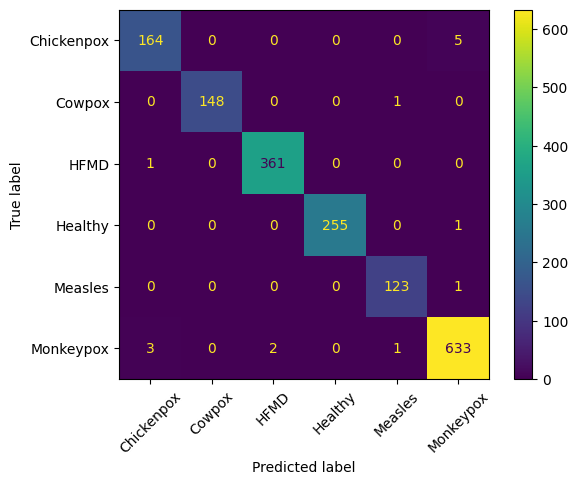

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, classification_report

test_ds = ds['test'].with_transform(transform)
test_outputs = trainer.predict(test_ds)

y_true = test_outputs.label_ids
y_pred = test_outputs.predictions.argmax(1)

labels = test_ds.features["label"].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

recall = recall_score(y_true, y_pred, average=None)
print(classification_report(y_true, y_pred))

# Print the recall for each class
for label, score in zip(labels, recall):
  print(f"Recall for {label}: {score:.2f}")

In [43]:
from transformers import pipeline
def getPrediction(image):
    model_name_or_path = 'google/vit-base-patch16-224-in21k'
    processor = AutoImageProcessor.from_pretrained(model_name_or_path, use_fast=True)
    vit = ViTForImageClassification.from_pretrained(save_dir)
    model = pipeline('image-classification', model=vit, feature_extractor=processor, device='cuda')

    result = model(image)
    return result

In [44]:
import cv2
from PIL import Image
import numpy as np

# Read the image using OpenCV
image = cv2.imread(r"C:\Users\kevin\Desktop\VSCode\Final Sem Project\dataset\Cowpox\CWP_01_01_5.jpg")

# Convert the OpenCV image (BGR format) to RGB format
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the NumPy array to a PIL Image
pil_image = Image.fromarray(image_rgb)

# Now call the getPrediction function
prediction = getPrediction(pil_image)

# Extract the label with the highest score
highest_prediction = max(prediction, key=lambda x: x['score'])

# Display the label and score as a percentage
score_percentage = highest_prediction['score'] * 100
print(f"{highest_prediction['label']}, {score_percentage:.2f}%")



Cowpox, 99.99%
